<a href="https://colab.research.google.com/github/ritesh-chafer/Deep-Lip-Reading/blob/main/test_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -u "/content/gdrive/MyDrive/Lip Reading/archive.zip" -d "/content/gdrive/MyDrive/Lip Reading/Lip_Dataset"

unzip:  cannot find or open /content/gdrive/MyDrive/Lip Reading/archive.zip, /content/gdrive/MyDrive/Lip Reading/archive.zip.zip or /content/gdrive/MyDrive/Lip Reading/archive.zip.ZIP.


In [ ]:
import numpy as np 
import pandas as pd

In [ ]:
!pip install dlib
!pip install imutils

In [ ]:
import numpy as np
import os
import imutils
import dlib
import cv2 

import imageio
from imutils import face_utils

In [ ]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
    	coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

In [ ]:
def crop_and_save_image(img, img_path, write_img_path, img_name):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('/content/gdrive/MyDrive/Lip Reading/Lip_Dataset/shape_predictor_68_face_landmarks.dat')
    # load the input image, resize it, and convert it to grayscale

    image = cv2.imread(img_path)
    image = imutils.resize(image, width=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    if len(rects) > 1:
    	print( "ERROR: more than one face detected")
    	return
    if len(rects) < 1:
    	print( "ERROR: no faces detected")
    	return

    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        name, i, j = 'mouth', 48, 68
        # clone = gray.copy()

        (x, y, w, h) = cv2.boundingRect(np.array([shape[i:j]]))        
        roi = gray[y:y+h, x:x+w]
        roi = imutils.resize(roi, width = 250, inter=cv2.INTER_CUBIC)        
        print('cropped/' + write_img_path)
        cv2.imwrite('cropped/' + write_img_path, roi)


In [ ]:
people = ['F01','F02']
data_types = ['words']
folder_enum = ['01','02']
instances = ['01','02']

words = ['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web']          
words_di = {i:words[i] for i in range(len(words))}

In [ ]:
import shutil

def crop_one_person():      
    os.mkdir('cropped')
    # people = ['F01']
    # data_types = ['words']
    # folder_enum = ['01']
    # instances = ['01']

    i = 1
    for person_ID in people:
        if not os.path.exists('cropped/' + person_ID ):
            os.mkdir('cropped/' + person_ID + '/')

        for data_type in data_types:
            if not os.path.exists('cropped/' + person_ID + '/' + data_type):
                os.mkdir('cropped/' + person_ID + '/' + data_type)

            for phrase_ID in folder_enum:
                if not os.path.exists('cropped/' + person_ID + '/' + data_type + '/' + phrase_ID):
                    # F01/phrases/01
                    os.mkdir('cropped/' + person_ID + '/' + data_type + '/' + phrase_ID)

                for instance_ID in instances:
                    # F01/phrases/01/01
                    directory = '/content/gdrive/MyDrive/Lip Reading/Lip_Dataset/dataset' + person_ID + '/' + data_type + '/' + phrase_ID + '/' + instance_ID + '/'
                    dir_temp = person_ID + '/' + data_type + '/' + phrase_ID + '/' + instance_ID + '/'
                    print(directory)
                    filelist = os.listdir(directory)
                    if not os.path.exists('cropped/' + person_ID + '/' + data_type + '/' + phrase_ID + '/' + instance_ID):
                        os.mkdir('cropped/' + person_ID + '/' + data_type + '/' + phrase_ID + '/' + instance_ID)

                        for img_name in filelist:
                            if img_name.startswith('color'):
                                image = imageio.imread(directory + '' + img_name)
                                crop_and_save_image(image, directory + '' + img_name,
                                                    dir_temp + '' + img_name, img_name)

    print(f'Iteration : {i}')
    i += 1
    shutil.rmtree('cropped')

In [ ]:
max_seq_length = 22

X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []


MAX_WIDTH = 100
MAX_HEIGHT = 100

In [ ]:
from skimage.transform import resize
import time

In [ ]:
t1 = time.time()
UNSEEN_VALIDATION_SPLIT = ['F07', 'M02']
UNSEEN_TEST_SPLIT = ['F04']

directory = "/content/gdrive/MyDrive/Lip Reading/Lip_Dataset/cropped/cropped"

for person_id in people:
    tx1 = time.time()
    for data_type in data_types:
        for word_index, word in enumerate(folder_enum):
#             print(f"Word : '{words[word_index]}'")
            for iteration in instances:
                path = os.path.join(directory, person_id, data_type, word, iteration)
                filelist = sorted(os.listdir(path + '/'))
                sequence = [] 
                for img_name in filelist:
                    if img_name.startswith('color'):
                        image = imageio.imread(path + '/' + img_name)
                        image = resize(image, (MAX_WIDTH, MAX_HEIGHT))
                        image = 255 * image
                        # Convert to integer data type pixels.
                        image = image.astype(np.uint8)
                        sequence.append(image)                        
                pad_array = [np.zeros((MAX_WIDTH, MAX_HEIGHT))]                            
                sequence.extend(pad_array * (max_seq_length - len(sequence)))
                sequence = np.array(sequence)
                                
                if person_id in UNSEEN_TEST_SPLIT:
                    X_test.append(sequence)
                    y_test.append(word_index)
                elif person_id in UNSEEN_VALIDATION_SPLIT:
                    X_val.append(sequence)
                    y_val.append(word_index)
                else:
                    X_train.append(sequence)
                    y_train.append(word_index)    
    tx2 = time.time()
    print(f'Finished reading images for person {person_id}. Time taken : {tx2 - tx1} secs.')    
    
t2 = time.time()
print(f"Time taken for creating constant size 3D Tensors from those cropped lip regions : {t2 - t1} secs.")

Finished reading images for person F01. Time taken : 24.180984020233154 secs.
Finished reading images for person F02. Time taken : 21.771908283233643 secs.
Time taken for creating constant size 3D Tensors from those cropped lip regions : 45.95487880706787 secs.


In [ ]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(8, 22, 100, 100)
(0,)
(0,)


In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(8,)
(0,)
(0,)


In [ ]:
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt

In [ ]:
model = Sequential()

# 1st layer group
model.add(Conv3D(64, (3, 3, 3), strides = 1, input_shape=(22, 100, 100, 1), activation='relu', padding='valid'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(128, (3, 3, 3), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(256, (2, 2, 2), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add((Flatten()))

# # FC layers group
model.add(Dense(4096, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(10, activation='softmax'))

#model.compile(loss='categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 98, 98, 64)    1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 49, 49, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 47, 47, 128)    221312    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 23, 23, 128)   0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 22, 22, 256)    262400    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 1, 11, 11, 256)   0

In [ ]:
X_train.shape


(8, 22, 100, 100)

In [ ]:
y_train.shape

(8,)

In [ ]:
t1 = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=45)
t2 = time.time()
print()
print(f"Training time : {t2 - t1} secs.")

Epoch 1/45
1/1 [==============================] - 31s 31s/step - loss: 8.0990 - accuracy: 0.1250
Epoch 2/45
1/1 [==============================] - 20s 20s/step - loss: 34.2427 - accuracy: 0.5000
Epoch 3/45
1/1 [==============================] - 20s 20s/step - loss: 132.3996 - accuracy: 0.5000
Epoch 4/45
1/1 [==============================] - 20s 20s/step - loss: 5.0177 - accuracy: 0.3750
Epoch 5/45
1/1 [==============================] - 21s 21s/step - loss: 5.5865 - accuracy: 0.5000
Epoch 6/45
1/1 [==============================] - 20s 20s/step - loss: 5.5998 - accuracy: 0.5000
Epoch 7/45
1/1 [==============================] - 20s 20s/step - loss: 2.0475 - accuracy: 0.2500
Epoch 8/45
1/1 [==============================] - 20s 20s/step - loss: 1.3108 - accuracy: 0.6250
Epoch 9/45
1/1 [==============================] - 20s 20s/step - loss: 2.4774 - accuracy: 0.5000
Epoch 10/45
1/1 [==============================] - 20s 20s/step - loss: 1.5274 - accuracy: 0.5000
Epoch 11/45
1/1 [=========

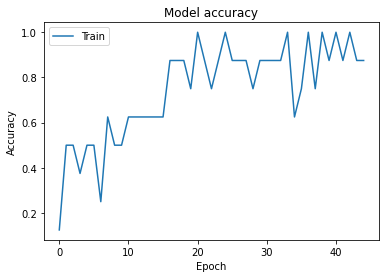

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

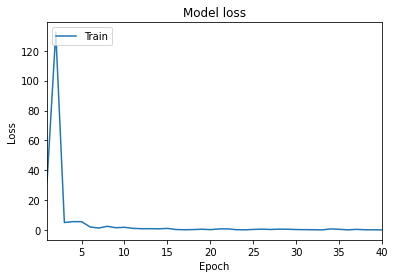

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(1, 40)
# plt.ylim(0, 3)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()